## Programming Assignment 5
#### In this assignment, you will be implementing Tomasi-Kanade	Factorization algorithm	for Rigid Structure from Motion.

### Task 1
#### Load the data file and generate a 2D image dataset	by generating an orthographic camera with optical axis paralle to the XY plane, which rotates around the teapot	in 10° increments and always looks towards the center of the object
#### Note: Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the teapot and visualize them

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import math
from numpy.linalg import inv

In [0]:
from scipy.io import loadmat
x = loadmat('teapot.mat')

In [0]:
a = []
b = []
c = []
for points in x['verts']:
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])

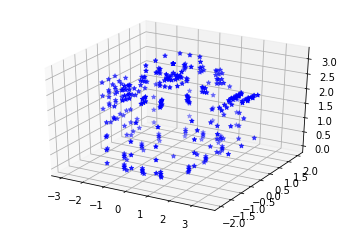

In [66]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,c, c='b', marker='*')

In [0]:
intrinsic = np.array([[1, 0, 0],[0, 1, 0]])

def rotation_matrix_y(angle):
    rot_angle=math.radians(angle)
    R = np.array([[math.cos(rot_angle),0,math.sin(rot_angle)],[0,1,0],[-math.sin(rot_angle),0,math.cos(rot_angle)]])
    return R      

In [68]:
### Your implementation comes here
R_mat = []
pts = np.array([a, b, c])
print("old2Dpts shape = ", pts.shape)

for x in range(0, 360, 10):
  R = rotation_matrix_y(x) # compute R (matrix that describes the rotation of the f frame) with an angle that increases by a factor of 10 degree on each iteration
  R = np.matmul(intrinsic, R) # converting the 3x3 R to 2x3 R
  R_mat.append(R)

new2Dpts = np.matmul(R_mat, pts) 
print("new2Dpts shape = ", new2Dpts.shape)

old2Dpts shape =  (3, 306)
new2Dpts shape =  (36, 2, 306)


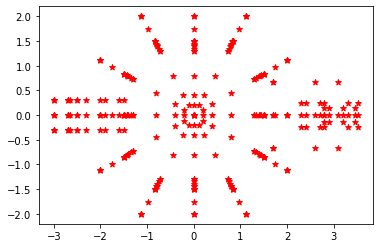

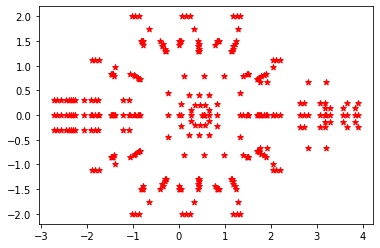

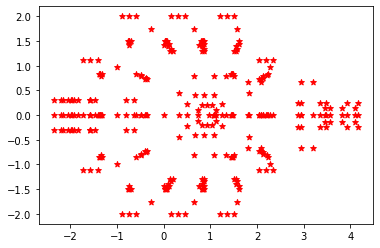

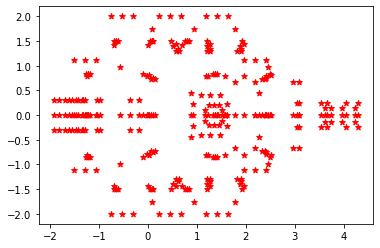

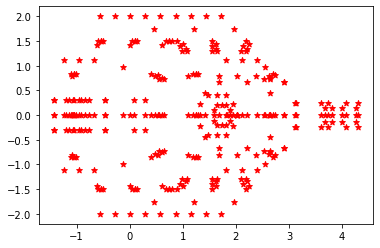

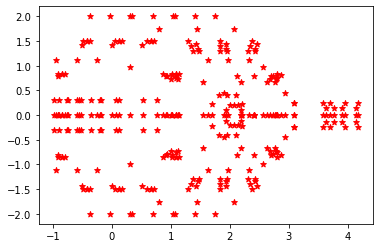

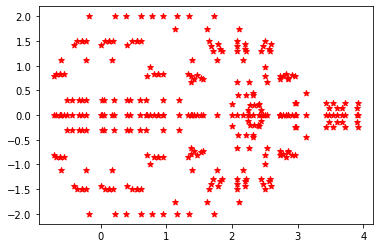

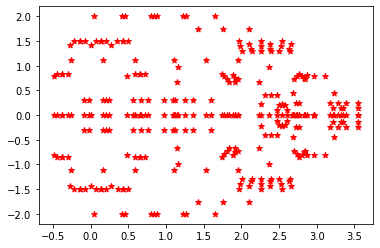

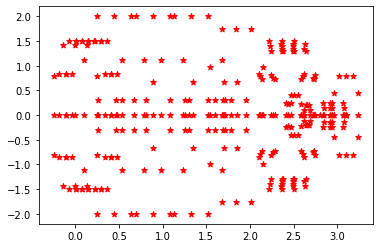

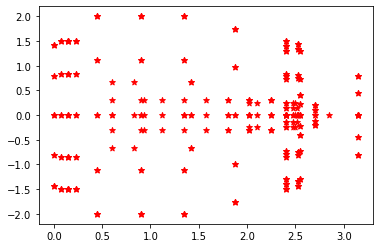

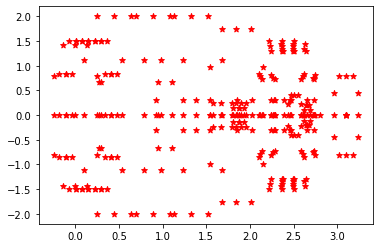

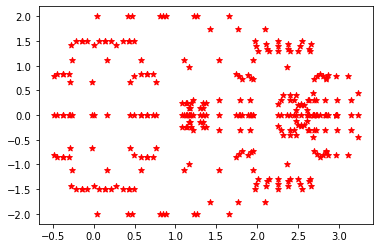

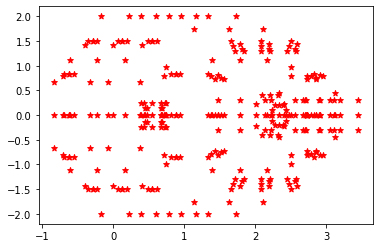

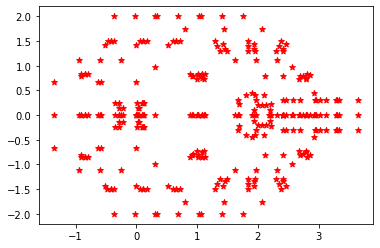

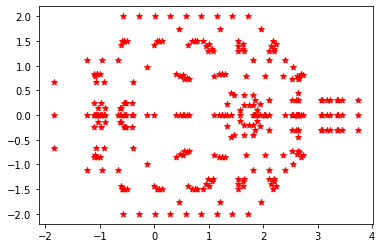

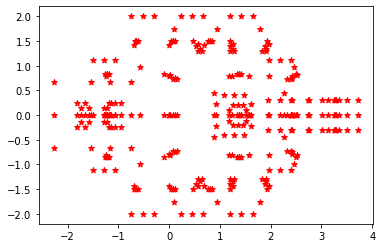

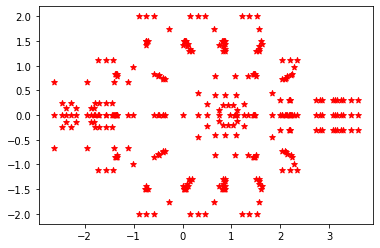

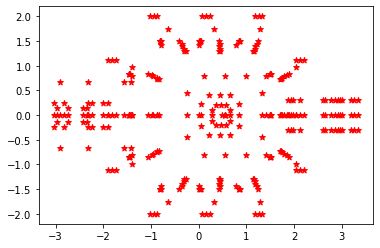

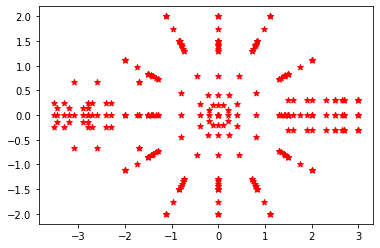

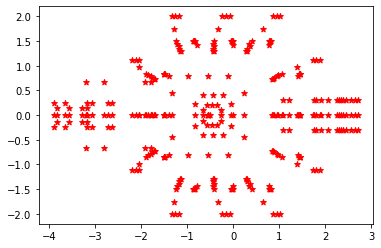

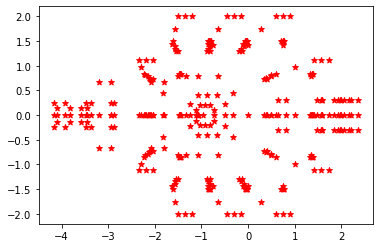

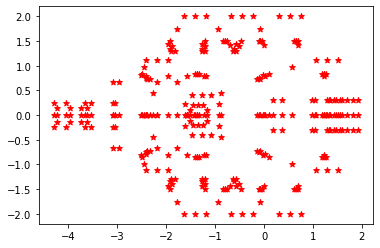

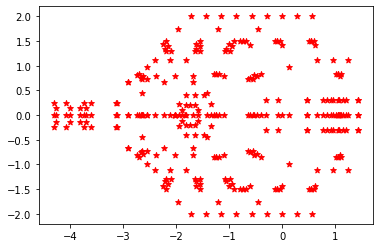

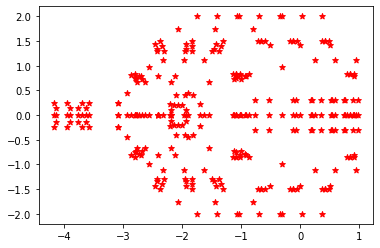

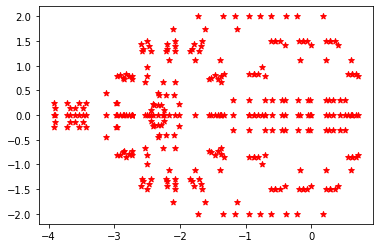

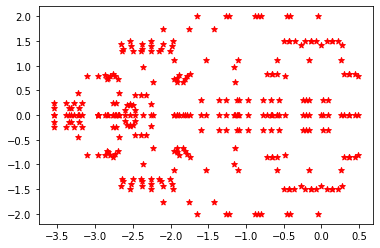

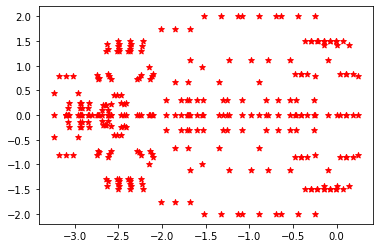

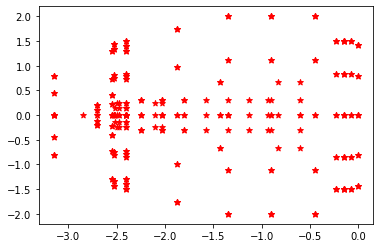

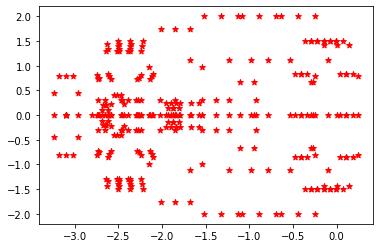

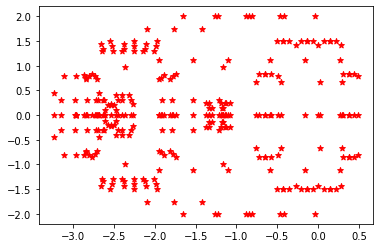

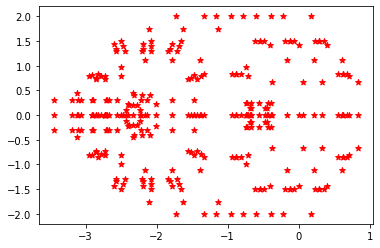

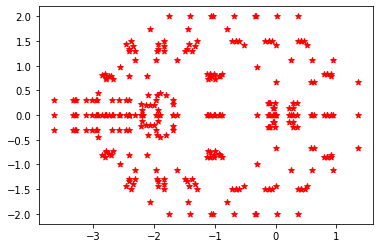

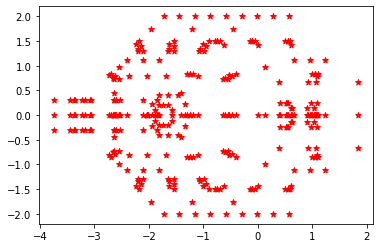

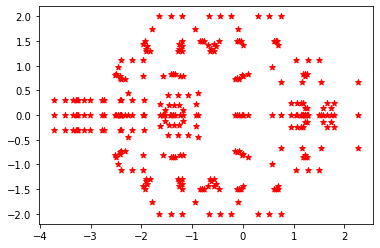

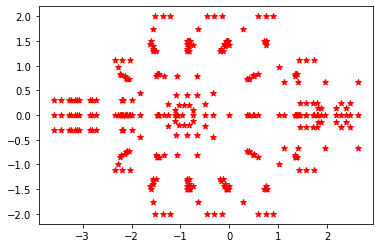

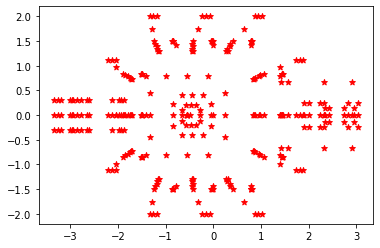

In [69]:
# visulaize the results by plotting the images
for x in new2Dpts: 
  plt.scatter(x[0], x[1], c='r', marker='*')  
  plt.show()

### Task 2
#### Use the data generated in previous task to generate a W matrix, and use that as input in Tomasi Kanade Factorization method to compute the 3D structure

In [70]:
### Your implementation for Tomasi Kanade Factorization method comes here
W = []
for pts in new2Dpts: 
  W.append(pts[0])
  W.append(pts[1])
W = np.array(W)

# rank of W is 3 
print("Shape of W: ", W.shape)
print("")
u, sigma, vh = np.linalg.svd(W) #get the u, diagnol(d) and v transpose from the svd
d = np.zeros((3,3))
d[0][0] = sigma[0]
d[1][1] = sigma[1]
d[2][2] = sigma[2]

u = u[:, 0:3] # take the first 3 columns of the U matrix, which can also be called R(hat)
print("New shape of u: ", u.shape)
print("")

print("New shape of d: ", d.shape)
print("")

vh = vh[0:3, :] # take the first 3 rows of the vh matrix
print("New shape of vh: ", vh.shape)
print("")

R_hat = u
S_hat = d.dot(vh)
print("R_hat shape: ", R_hat.shape)
print("S_hat shape: ", S_hat.shape)

Shape of W:  (72, 306)

New shape of u:  (72, 3)

New shape of d:  (3, 3)

New shape of vh:  (3, 306)

R_hat shape:  (72, 3)
S_hat shape:  (3, 306)


In [74]:
A = []
B = []

# the row expression for each 2 rows from R_hat will remain the same, only the values of r will change
# from the 2x2 matix obtained by multiplying R1_hat, QQ_transpose and R1_hat_transpose. I chose the
# 1st, 2nd and 4th value, thus the orthonormal values arw 1 0 1  
def finding_rows(r1, r2, r3, r4, r5, r6): 
  row1 = [r1 ** 2, 2 * r1 * r2, r1 * r3, (r1 * r3) + (r2 ** 2), 2 * r2 * r3, r3 ** 2]
  row2 = [r1 * r4, (r2 * r4) + (r1 * r5), r1 * r6, (r3 * r4) + (r2 * r5), (r3 * r5) + (r2 * r6), r3 * r6]
  row3 = [r4 ** 2, 2 * r4 * r5, r4 * r6, (r4 * r6) + (r5 ** 2), r5 * r6, r6 ** 2]
  A.append(row1)
  B.append(1)
  A.append(row2)
  B.append(0)
  A.append(row3)
  B.append(1)

i1 = 0
i2 = 2
for x in range(36):  # looping over R_hat to retreive the 2 consecutive rows for each image  
  r = R_hat[i1:i2, :]
  r1 = r[0][0]
  r2 = r[0][1]
  r3 = r[0][2]
  r4 = r[1][0]
  r5 = r[1][1]
  r6 = r[1][2]
  finding_rows(r1, r2, r3, r4, r5, r6)
  i1 += 2
  i2 += 2

# Aq = B
# q = inv(A * A_transpose)(A_tanspose * B)
A= np.array(A) # A
print("A shape = ", A.shape)

B = np.array(B) # B
print("B shape = ", B.shape)

A_transpose = A.transpose() # A_tanspose
print("A_Transpose shape = ", A.shape)

val1 = inv(np.matmul(A_transpose, A)) # inv(A * A_transpose)
print("At * A shape = ", val1.shape)

val2 = np.matmul(A_transpose, B) # (A_transpose * B)
print("At * B shape = ", val2.shape)

q = np.array(np.matmul(val1, val2)) # [q1,q2,q3,q4,q5,q6]
q1 = q[0]
q2 = q[1]
q3 = q[2]
q4 = q[3]
q5 = q[4]
q6 = q[5]

# 3x3 symmetic matrix -> Q * Q_transpose
# [[q1,q2,q3],
#  [q2,q4,q5],
#  [q4,q5,q6]]
QQt = np.array([[q1,q2,q3], [q2,q4,q5], [q4,q5,q6]]) # convert the six q values into the (3x3) symmetric matrix 

Q = np.linalg.cholesky(QQt) # gives us the Q translation matrix
Q_inv = inv(Q) # find the inverse of the Q matrix

R = np.matmul(R_hat, Q) # the real R
S = np.matmul(Q_inv, S_hat) # the 3D structure we were looking for

W = np.matmul(R, S) # the final W
print("R shape = ", R.shape)
print("S shape = ", S.shape)
print("W shape = ", W.shape)

A shape =  (108, 6)
B shape =  (108,)
A_Transpose shape =  (108, 6)
At * A shape =  (6, 6)
At * B shape =  (6,)
R shape =  (72, 3)
S shape =  (3, 306)
W shape =  (72, 306)


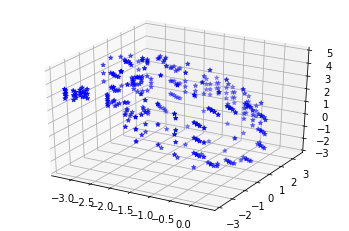

In [72]:
# Plot the reconstructed mode

# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the reconstructed 3D points are 
# in variables a1, b1 and c1 respectively, the reconstructed model can be plotted as:

a1 = S[0]
b1 = S[1]
c1 = S[2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a1,b1,c1, c='b', marker='*')

In [73]:
## Evaluate your reconstruction
# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the 3D points that you have reconstructed are 
# in variables a1, b1 and c1 respectively, the error in reconstruction can be calcualted as:

err = 0.0
j = 0
for i in range(len(a1)):
  err = err + math.sqrt( ((a1[i]-a[i])*(a1[i]-a[i])) + ((b1[i]-b[i])*(b1[i]-b[i])) + ((c1[i]-c[i])*(c1[i]-c[i])) )
  j=j+1
  
print ("Mean Euclidean Error : ",(err/j))

Mean Euclidean Error :  3.5518898862390236
